<a href="https://colab.research.google.com/github/Padawanh/WIMyD/blob/main/Anomaly%20Detection%20-%20Identifying%20harvested%20forest%20areas%20with%20the%20GEE%20Python%20API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Baixar dados do projeto](https://drive.google.com/drive/folders/1Ho2UmkDeDMOQzKD9sAHal4eZPZLy1tbh?usp=sharing)



# Instalação, carregamento e conexões

In [ ]:
!pip install -U pip
!pip install geopandas
!pip install ipygee
!pip install earthengine-api
!pip install geemap
!pip install pycaret
!pip install statsmodels


In [ ]:
#Para geo ETL
import ee
from ipygee import*
import geopandas as gp
import geemap
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.anomaly import setup , create_model , assign_model , plot_model , predict_model , save_model , load_model 



Definindo que os gráficos tem que ser plotados no próprio Jupyter Notebook

In [2]:
%matplotlib inline

Conectando com o Google Earth Engine através da API python

In [3]:
ee.Authenticate()
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=VJ6-4F58Qn3FXHbQ6j9g5cN1k-mUisUeEx1yeqzcsIA&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgh26tFee6w5ru6X0ZfXOf2M6VE80QuZaQdMWblrW-J5w3BJrRdLG8

Successfully saved authorization token.


Conectando com google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Carregando Dados

Delimitando intervalo de imagem da área de estudo

In [5]:
#Pasta do projeto
FolderProj = '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection - Identifying harvested areas with sentinel imagery with the GEE/'
PointFiler = FolderProj+'/pointsPlantedForest.shp'
pointsPlantedForest = gp.read_file(PointFiler)
#Faço uma cópia do arquivo de pontos. Dissolvo (ou resumo) os vários pontos em um só.
FileExtend = pointsPlantedForest.copy().dissolve() 
#Crio um polígono do tamanho das proporções máximas do polígono dissolvido anteriomentee aumento em 5 km de borda.
FileExtend['geometry'] = FileExtend['geometry'].envelope.buffer(5000)
pointsPlantedForest

,FID,geometry
0,0,POINT (336770.823 7845740.541)
1,1,POINT (250914.377 7833925.849)
2,2,POINT (319067.735 7833508.263)
3,3,POINT (246934.960 7830454.942)
4,4,POINT (255524.521 7830511.025)
...,...,...
503,503,POINT (405701.800 7672255.421)
504,504,POINT (405860.102 7671219.127)
505,505,POINT (405208.836 7665590.257)
506,506,POINT (401320.942 7665766.906)


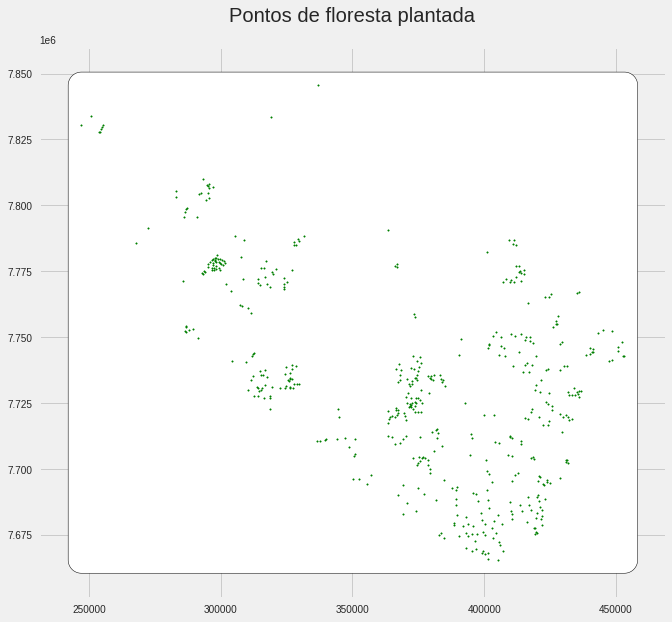

In [6]:
#Preparo a plotagem
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 10))
FileExtend.plot(ax=ax, color='white',edgecolor='black')
pointsPlantedForest.plot(ax=ax, color='green',markersize=2)
plt.title('Pontos de floresta plantada',pad = 25)
plt.show()

Carregando dados em objetos que interagem com a API do Google Earth Engine.

In [7]:
Points = geemap.shp_to_ee(PointFiler) 
AOI = geemap.geopandas_to_ee(FileExtend)

In [8]:
startDateviz3 = ee.Date.fromYMD(2019,1,1);
endDateviz3 = ee.Date.fromYMD(2019,3,30);
collectionviz3 = ee.ImageCollection('MODIS/006/MCD43A4').filterDate(startDateviz3,endDateviz3).filterBounds(AOI)
S2_2019 = collectionviz3.select([ 'Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band4',  'Nadir_Reflectance_Band3']).median().clip(AOI)
vis_params = {  'min': 0.0,  'max': 4000.0, 'gamma': 1.4  }

In [9]:
Map = geemap.Map()
Map.addLayer(S2_2019,vis_params,'MODIS - 2019')
Map.addLayer(Points,name='Amostras')
Map.addLayer(AOI , name='Área de Estudo')
Map.center_object(Points)
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

#Extraindo dados série de dados NDVI


##Extraindo dados com a API do GEE

In [10]:
#Função para transformar os valores dos pixeis para o intervalo de -1 a 1 em tipo float e 
#insere a propriedade da data das imagens
def NDVIf(image):
  return image.expression('float(b("NDVI")/10000)').copyProperties(image, ["system:time_start"])
#Definindo o intervalo de data da serie de imagens.
startDate = ee.Date.fromYMD(2009,1,1);
endDate = ee.Date.fromYMD(2019,12,31);
#Aplico os filtros na coleção de imagens NDVI MODIS, de área, datas e a função de representação de valores do NDVI
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
NDVI_Modis = modis.filterBounds(AOI).filterDate(startDate,endDate).map(NDVIf)
#Quantidade de imagens na coleção
print(NDVI_Modis.size().getInfo())

253


Essa função extraí a média dos valores NDVI das imagens disponíveis para o conjunto de pontos de floresta plantada nas datas de obtenção de cada imagem ou conjunto de imagens. Terminando assim o processamento espacial das informações.

In [11]:
#Função do ipygee para obtenção de gráficos derivados de coleção de imagens do GEE
point_ndvi_Modis = chart.Image.series(**{'imageCollection': NDVI_Modis,
                                   'region': Points,
                                   'reducer': ee.Reducer.mean(),
                                   'bands' : 'NDVI',
                                   'scale': 25,
                                   'xProperty': 'system:time_start'})
point_ndvi_Modis.renderWidget(width='40%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

#Análise e Exploração dos Dados

In [12]:
#Crio um dataframe pandas com os dados da serie temporal
p1_dataframeModis=point_ndvi_Modis.dataframe
p1_dataframeModis.describe()

,NDVI
count,253.000000
mean,0.740731
std,0.065425
min,0.328917
25%,0.703330
50%,0.748621
75%,0.790043
max,0.843331


Plotando a série temporal

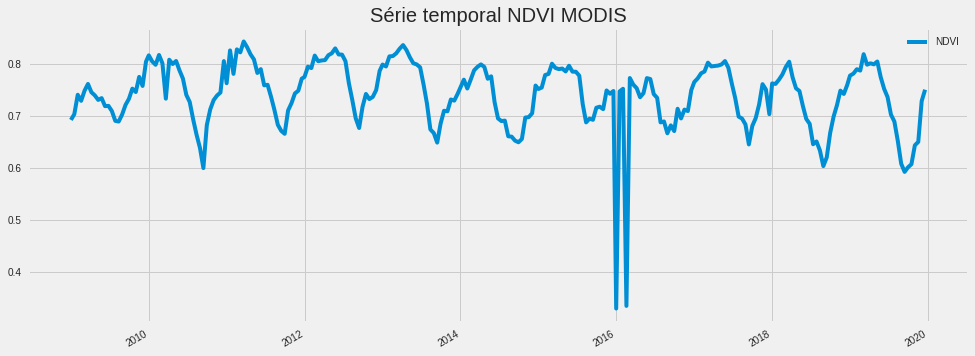

In [13]:
p1_dataframeModis.plot(figsize=(15, 6))
plt.title('Série temporal NDVI MODIS')
plt.legend(loc='best')
plt.show()


In [43]:
p1_dataframeModis.head()

,NDVI,dia_do_ano,semana_do_ano
2009-01-01,0.692229,1,1
2009-01-17,0.703369,17,3
2009-02-02,0.740709,33,6
2009-02-18,0.729057,49,8
2009-03-06,0.748573,65,10


##Avaliando outliers

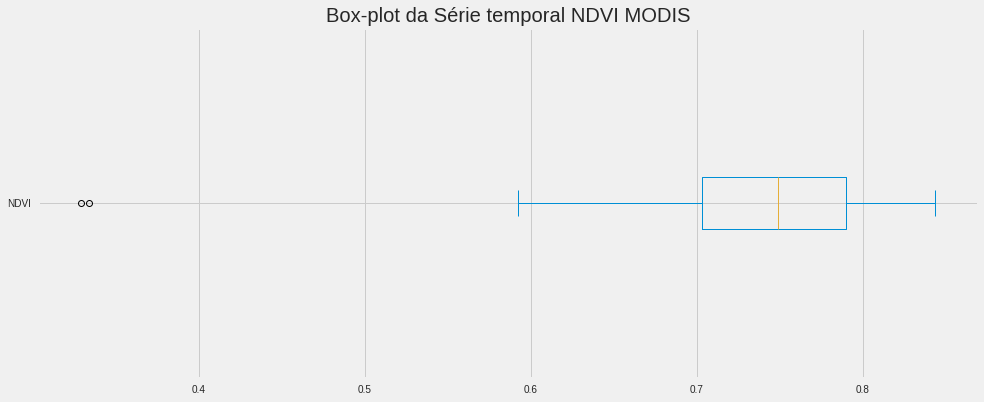

In [15]:
p1_dataframeModis.plot(figsize=(15, 6),kind='box',vert=False)
plt.title('Box-plot da Série temporal NDVI MODIS')
plt.show()

In [16]:
#Percentual de outliers
str(round((len(p1_dataframeModis[p1_dataframeModis['NDVI']<0.4])/len(p1_dataframeModis))*100,2)) + " % dos dados são outliers"


'0.79 % dos dados são outliers'

#Modelando no PyCaret

###Enriquecendo o dado para modelagem

In [17]:
dataset = p1_dataframeModis
dataset['dia_do_ano'] = [i.dayofyear for i in dataset.index]
dataset['semana_do_ano'] = [i.weekofyear for i in dataset.index]

##Separando o dado para treinamento e teste

In [18]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (240, 3)
Unseen Data For Predictions: (13, 3)


In [19]:
data.head(5)

,NDVI,dia_do_ano,semana_do_ano
2017-04-23,0.796945,113,16
2010-03-22,0.733197,81,12
2016-12-02,0.709327,337,48
2015-02-02,0.778705,33,6
2012-02-18,0.816190,49,7


##Carregando o dado no PyCaret

In [20]:
exp_ano101 = setup(data, normalize = True, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(240, 3)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(240, 3)"
9,CPU Jobs,-1


##Criando e avaliando o modelo

In [21]:
#Percentual de outliers
str(round((len(p1_dataframeModis[p1_dataframeModis['NDVI']<0.4])/len(p1_dataframeModis))*100,2)) + " % dos dados são outliers"

'0.79 % dos dados são outliers'

In [22]:
iforest = create_model('iforest', fraction = 0.01)
iforest_results = assign_model(iforest)
iforest_results[iforest_results['Anomaly'] == 1].head()

,NDVI,dia_do_ano,semana_do_ano,Anomaly,Anomaly_Score
2012-01-01,0.775073,1,52,1,0.007619
2016-02-18,0.333979,49,7,1,0.098826
2016-01-01,0.328917,1,53,1,0.147167


In [23]:
plot_model(iforest,feature="NDVI")

In [24]:
data_unseen['NDVI'][0] = 0.5
unseen_predictions = predict_model(iforest, data=data_unseen)
unseen_predictions[unseen_predictions['Anomaly'] == 1].head()

,NDVI,dia_do_ano,semana_do_ano,Anomaly,Anomaly_Score
2009-11-17,0.500000,321,47,1,0.014261
2010-01-01,0.816564,1,53,1,0.028997


Salvando o modelo

In [25]:
save_model(iforest,'Anomaly_Detection_NDVI_IForest_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None...
                 ('fix_perfect', 'passthrough'),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  IFo

#Pondo em prática

Carregando o modelo

In [26]:
Anomaly_Detection_Model = load_model('Anomaly_Detection_NDVI_IForest_Model')

Transformation Pipeline and Model Successfully Loaded


##Testando modelo em uma série temporal de um local específico

In [27]:
#Coordenadas Talhão 
geoP = ee.Geometry.Point([
  -51.8186059,-20.4644763
                          ])
start , end = '2009-01-01','2019-12-31'
#Definindo o intervalo de data das imagens.
startDate = ee.Date.fromYMD(int(start[:4]),int(start[:7][-2:]),int(start[-2:]));
endDate = ee.Date.fromYMD(int(end[:4]),int(end[:7][-2:]),int(end[-2:]));

In [28]:
#Aplico os filtros na coleção de imagens NDVI MODIS, de área, datas e 
#representação de valores do NDVI
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
NDVI_Modis = modis.filterBounds(geoP).filterDate(startDate,endDate).map(NDVIf)
#Quantidade de imagens na coleção
print(NDVI_Modis.size().getInfo())

253


In [29]:
#Função do ipygee para obtenção de gráficos derivados de coleção de imagens do GEE
point_ndvi_Modis = chart.Image.series(**{'imageCollection': NDVI_Modis,
                                   'region': geoP,
                                   'reducer': ee.Reducer.mean(),
                                   'bands' : 'NDVI',
                                   'scale': 25,
                                   'xProperty': 'system:time_start'})
point_ndvi_Modis.renderWidget(width='40%')
p1_dataframeModis2=point_ndvi_Modis.dataframe

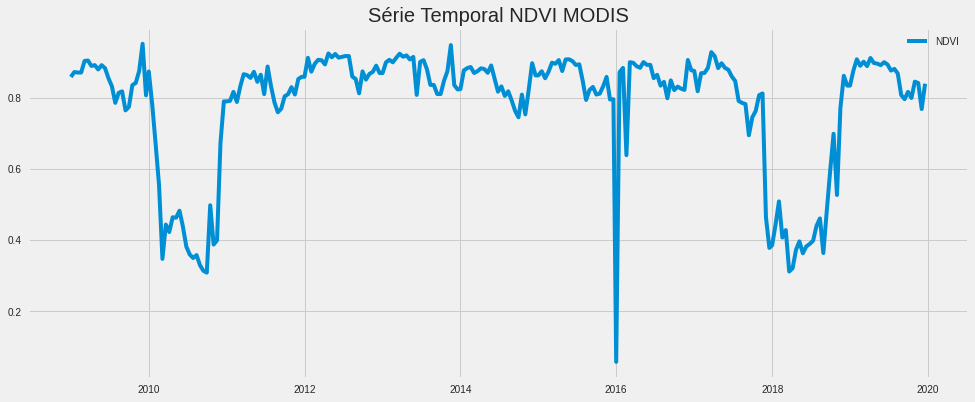

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(p1_dataframeModis2['NDVI'],label='NDVI'); 
plt.title('Série Temporal NDVI MODIS')
plt.legend(loc='best')
plt.style.use('fivethirtyeight')
plt.show()

In [31]:
dataset = p1_dataframeModis2
dataset['dia_do_ano'] = [i.dayofyear for i in dataset.index]
dataset['semana_do_ano'] = [i.weekofyear for i in dataset.index]
new_prediction = predict_model(Anomaly_Detection_Model, data=dataset)
#Excluindo anomalias positivas
anomaly = new_prediction[new_prediction['Anomaly'] == 1][new_prediction['NDVI']<0.6]


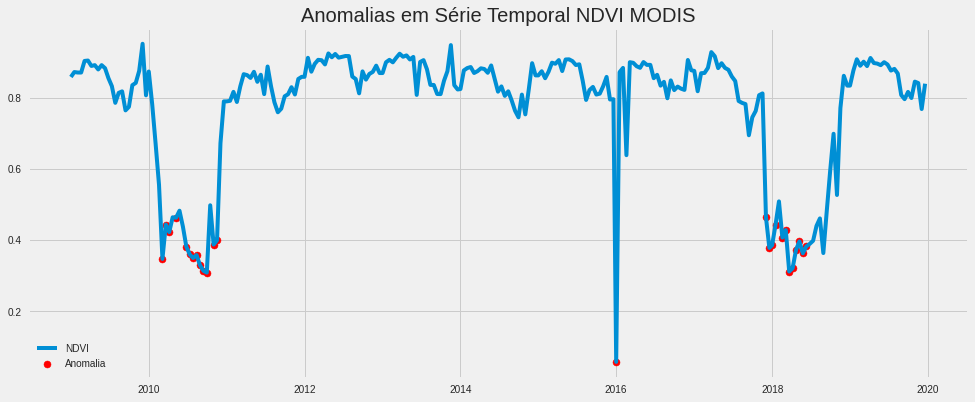

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(anomaly.index,anomaly['NDVI'],color='red',label='Anomalia');
ax.plot(p1_dataframeModis2['NDVI'],label='NDVI'); 
plt.title('Anomalias em Série Temporal NDVI MODIS')
plt.legend(loc='best')
plt.style.use('fivethirtyeight')
plt.show()

In [33]:
anomaly

,NDVI,dia_do_ano,semana_do_ano,Anomaly,Anomaly_Score
2010-03-06,0.3474,65,9,1,0.079870
2010-03-22,0.4437,81,12,1,0.022733
2010-04-07,0.4228,97,14,1,0.013898
2010-05-09,0.4629,129,18,1,0.008064
2010-06-26,0.3819,177,25,1,0.009181
2010-07-12,0.3598,193,28,1,0.007529
2010-07-28,0.3499,209,30,1,0.007921
2010-08-13,0.3581,225,32,1,0.003854
2010-08-29,0.3298,241,34,1,0.026017
2010-09-14,0.3141,257,37,1,0.011034


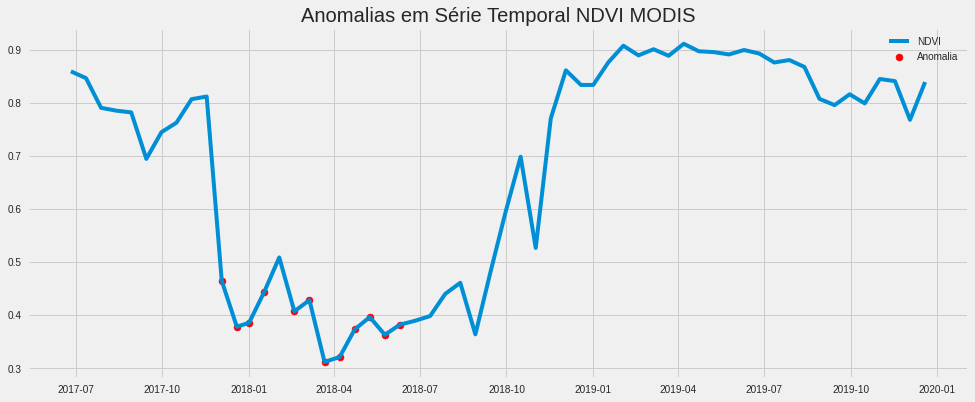

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(anomaly.index[14:],anomaly['NDVI'][14:],color='red',label='Anomalia');
ax.plot(p1_dataframeModis2['NDVI'][195:],label='NDVI'); 
plt.title('Anomalias em Série Temporal NDVI MODIS')
plt.legend(loc='best')
plt.style.use('fivethirtyeight')
plt.show()

#Processamento

In [44]:
start , end = '2017-10-01','2018-03-31'
buffer , porcentagemNuvem = 500 , 10

In [45]:
Map = geemap.Map()

pointColheita = ee.Feature(geoP)
roi = pointColheita.buffer(buffer)
geometry = geoP
Map.centerObject(geometry,20)
s2 = ee.ImageCollection("COPERNICUS/S2")


In [46]:


# Write a function for Cloud masking
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])

filtered = s2 \
  .filter(ee.Filter.date(start , end )) \
  .filter(ee.Filter.intersects('.geo', geometry)) \
  .map(maskS2clouds).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',porcentagemNuvem))


imgCol = filtered.map(lambda img: img.clip(roi))

rgbVis = {
  'min': 0.0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}

'''
Map.addLayer(imgCol, rgbVis, 'RGB Composite')
Map.addLayer(geometry,name='Amostras')
Map
'''

"\nMap.addLayer(imgCol, rgbVis, 'RGB Composite')\nMap.addLayer(geometry,name='Amostras')\nMap\n"

In [47]:
print(imgCol.size().getInfo())

7


In [48]:
time = [str(datetime.datetime.fromtimestamp(x/1000).date()) for x in imgCol.aggregate_array('system:time_start').getInfo()]

#Resultado

In [49]:
time = [str(datetime.datetime.fromtimestamp(x/1000).date()) for x in imgCol.aggregate_array('system:time_start').getInfo()]

In [50]:
#work_dir = os.path.join(os.path.expanduser("~"), 'Downloads')
work_dir = FolderProj
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
out_gif = os.path.join(work_dir, "landsat_ts.gif")
geemap.download_ee_video(imgCol, rgbVis, out_gif)
texted_gif = os.path.join(work_dir, "landsat_ts_text.gif")
geemap.add_text_to_gif(out_gif, texted_gif, xy=('3%', '5%'), text_sequence=time, font_size=15, font_color='#ffffff', add_progress_bar=False,duration = 1250)

Generating URL...
Please wait ...
The GIF image has been saved to: /content/drive/MyDrive/Colab Notebooks/Anomaly Detection - Identifying harvested areas with sentinel imagery with the GEE/landsat_ts.gif


In [51]:
geemap.show_image(texted_gif)

Output()